# Cointegration x Multiple Linear Regression -> Markov Chain 

Feed multiple linear regression output into the transitional matrix for the Markov Chain transition probabilities between states.

In [4]:
# Libaries 
# Libraries and Modules used
import MetaTrader5 as mt5 
import pandas as pd
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")
import numpy as np
# warnings.filterwarnings("ignore")
mt5.initialize()
# Replace following with your MT5 Account Login
account=51434456 # 
password="9UpBvVzc"
server = 'ICMarkets-Demo'

# Function to get rates from MT5 
def get_rates(pair1, timeframe, x):
    pair1 = pd.DataFrame(mt5.copy_rates_from_pos(pair1, timeframe, 0, x))
    pair1['time'] = pd.to_datetime(pair1['time'], unit = 's')
    return pair1['close']

## Cointegration Code

In [5]:
first_order_pairs = [('AUDUSD.a', 'NZDUSD.a'), 
                     ('EURUSD.a', 'GBPUSD.a'),
                     ('EURNZD.a', 'GBPNZD.a')]

In [6]:
from statsmodels.tsa.stattools import adfuller

def get_data(symbol, bars=1000):
    '''Fetches price data for a symbol'''
    rates = pd.DataFrame(mt5.copy_rates_from_pos(symbol, mt5.TIMEFRAME_D1, 0, bars))
    rates['time'] = pd.to_datetime(rates['time'], unit = 's')
    return rates[['time', 'close']].set_index('time')

def compute_spread(pair):
    '''Computes the spread for a given pair'''
    data1 = get_data(pair[0])
    data2 = get_data(pair[1])
    merged = data1.join(data2, lsuffix="_x", rsuffix="_y")
    spread = merged['close_x'] - merged['close_y']
    return spread.dropna()

def arima_get_data(symbol, bars = 6000):
    rates = pd.DataFrame(mt5.copy_rates_from_pos(symbol, mt5.TIMEFRAME_H4, 0, bars))
    rates['time'] = pd.to_datetime(rates['time'], unit = 's')
    return rates[['time', 'close']].set_index('time')

def arima_compute_spread(pair):
    data1 = arima_get_data(pair[0])
    data2 = arima_get_data(pair[1])
    merged = data1.join(data2, lsuffix="_x", rsuffix="_y")
    spread = merged['close_x'] - merged['close_y']
    return spread.dropna()

def adf_test(spread):
    '''Runs ADF test on a spread series'''
    result = adfuller(spread)
    return {'ADF Statistic': result[0], 'p-value': result[1], 'Critical Values': result[4]}


In [7]:
# Running the tests
results = {}
for pair in first_order_pairs:
    print(f'Running through pair {pair}')
    spread = compute_spread(pair)
    results[pair] = adf_test(spread)

# Convert results to a DataFrame
df = pd.DataFrame(results).T

df

Running through pair ('AUDUSD.a', 'NZDUSD.a')
Running through pair ('EURUSD.a', 'GBPUSD.a')
Running through pair ('EURNZD.a', 'GBPNZD.a')


,,ADF Statistic,p-value,Critical Values
AUDUSD.a,NZDUSD.a,-2.908899,0.044323,"{'1%': -3.4369193380671, '5%': -2.864440383452..."
EURUSD.a,GBPUSD.a,-2.699557,0.074115,"{'1%': -3.4369391965679257, '5%': -2.864449141..."
EURNZD.a,GBPNZD.a,-2.831296,0.053941,"{'1%': -3.4369391965679257, '5%': -2.864449141..."


In [8]:
coint_pairs = []

for idx, row in df.iterrows():
    if row['ADF Statistic'] < row['Critical Values']['10%']:
        print(f'Pair {idx} is cointegrated')
        coint_pairs.append(idx)
        
coint_dict = {}

for pair in coint_pairs:
    coint_dict[pair] = compute_spread(pair)

Pair ('AUDUSD.a', 'NZDUSD.a') is cointegrated
Pair ('EURUSD.a', 'GBPUSD.a') is cointegrated
Pair ('EURNZD.a', 'GBPNZD.a') is cointegrated


## Markov Chain + Neural Network

In [9]:
def rsi(data, length):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)

    avg_gain = gain.rolling(window=14, min_periods=1).mean()
    avg_loss = loss.rolling(window=14, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

In [10]:
def generate_features(data):
    fiften_day_avg = data.rolling(window=15).mean().round(5)
    sixty_day_avg = data.rolling(window=60).mean().round(5)

    features_df = pd.DataFrame(index=data.index)
    n = 10
    features_df['close'] = data
    features_df['Shifted_Close'] = data.shift(1)
    features_df['momentum'] = data - data.shift(n)
    features_df['fiften_day_avg'] = fiften_day_avg
    features_df['sixty_day_avg'] = sixty_day_avg
    features_df['RSI'] = rsi(data, length=14)
    features_df['ROC'] = ((data - data.shift(n)) / data.shift(n)) * 100
    
    # Remove rows with any NA values
    features_df.dropna(inplace=True)
    return features_df

head_features = {}

for pair, data in coint_dict.items():
    features = generate_features(data)
    head_features[pair] = features

In [11]:
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

def train_neural_network(dataframe):
    n_features = dataframe.shape[1]
    X_train = dataframe.drop(columns='close')
    y_train = dataframe['close']

    # 1. Train a simple neural network
    model = Sequential()
    model.add(Input(shape=(n_features-1,))) # Excluding 'close' column
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))  # We'll extract activations from this layer
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=100, batch_size=32)

    # 2. Extract activations from the second last layer
    activation_model = Model(inputs=model.input, outputs=model.layers[-2].output)
    activations = activation_model.predict(X_train)

    # 3. Cluster on these activations
    activations_normalized = StandardScaler().fit_transform(activations)
    db = DBSCAN(eps=0.5, min_samples=5).fit(activations_normalized)
    
    labels = db.labels_
    
    return labels, activation_model, db # Return the states

states_dict = {}

for pair, dataframe in head_features.items():
    states, activation_model, db = train_neural_network(dataframe)
    states_dict[pair] = {
        "states": states,
        "activation_model": activation_model,
        "DB_scan": db,
        "data": dataframe.drop(columns='close')  # Store data for NearestNeighbors fitting in StateClassifier
    }

ModuleNotFoundError: No module named 'keras'

### Chain

In [12]:
from collections import defaultdict

In [13]:
class MarkovChain:
    def __init__(self, states, states_dict):
        self.states = states
        self.transition_matrix = {}
        self.classifier = StateClassifier(states_dict)
        self.previous_state = None
    
    def update_transition_matrix(self, current_state, pair):
        # Check and initialize the outer dictionary for the pair if needed
        if pair not in self.transition_matrix:
            self.transition_matrix[pair] = {}

        # Check and initialize the second level dictionary for previous_state if needed
        if self.previous_state not in self.transition_matrix[pair]:
            self.transition_matrix[pair][self.previous_state] = {}

        # Check and initialize the innermost dictionary for current_state if needed
        if current_state not in self.transition_matrix[pair][self.previous_state]:
            self.transition_matrix[pair][self.previous_state][current_state] = 0

        # Now you can safely update the count
        self.transition_matrix[pair][self.previous_state][current_state] += 1

    def classify_samples(self, samples, pair):
        return [self.classifier.classify_sample(sample.reshape(1, -1), pair) for sample in samples]

    def get_transition_matrix(self):
        return self.transition_matrix
    
    def create_transition_matrix(self, transitions_dict):

        result = {}

        for pair, transitions in transitions_dict.items():
            transition_counts = {}
            for from_state, to_states in transitions.items():
                for to_state, count in to_states.items():
                    if from_state not in transition_counts:
                        transition_counts[from_state] = {}
                    if to_state not in transition_counts[from_state]:
                        transition_counts[from_state][to_state] = 0
                    transition_counts[from_state][to_state] += count

            probability_matrix = {}
            for from_state, to_states in transition_counts.items():
                total_transitions = sum(to_states.values())
                probability_matrix[from_state] = {to_state: count / total_transitions for to_state, count in to_states.items()}

            result[pair] = probability_matrix

        return result
    
    def substate_update_transition_matrix(self, original_matrix, pair, sub_states, meta_state):
        print("Debugging Inside Function:")
        print("Type of meta_state:", type(meta_state))
        print("Value of meta_state:", meta_state)
        print("Type of new_transitions:", type(new_transitions))
        print("Value of new_transitions:", new_transitions)
        print("Type of original_matrix:", type(original_matrix))
        print("Value of original_matrix:", original_matrix)

        new_transitions = defaultdict(lambda: defaultdict(int))
        # Adding transitions between sub-states
        for i in range(len(sub_states) - 1):
            from_state = f"{meta_state}-{sub_states[i]}"
            to_state = f"{meta_state}-{sub_states[i + 1]}"
            new_transitions[from_state][to_state] += 1

        # Adding transitions from meta-state to the first sub-state in each sequence
        new_transitions[meta_state][f"{meta_state}-{sub_states[0]}"] += 1
        # Adding transitions from the last sub-state in each sequence to the meta-state
        new_transitions[f"{meta_state}-{sub_states[-1]}"][meta_state] += 1

        # Merge new transitions into the original matrix for the specific pair
        if pair not in original_matrix:
            original_matrix[pair] = {}

        for from_state, to_states in new_transitions.items():
            if from_state not in original_matrix[pair]:
                original_matrix[pair][from_state] = {}
            for to_state, count in to_states.items():
                if to_state not in original_matrix[pair][from_state]:
                    original_matrix[pair][from_state][to_state] = 0
                original_matrix[pair][from_state][to_state] += count

    # Function to create a new probability matrix
    def substate_create_new_probability_matrix(self, original_matrix):
        new_prob_matrix = {}
        for pair, transitions in original_matrix.items():
            pair_prob_matrix = {}
            for from_state, to_states in transitions.items():
                # Remove this line to include all types of states
                if isinstance(from_state, (int, np.int64)) or (isinstance(from_state, str)):  # Add this line to check the type of key
                    total_transitions = sum(to_states.values())
                    pair_prob_matrix[from_state] = {to_state: count / total_transitions for to_state, count in to_states.items()}
            new_prob_matrix[pair] = pair_prob_matrix
        return new_prob_matrix


class StateClassifier:
    def __init__(self, states_dict):
        self.states_dict = states_dict
        # Initialize NearestNeighbors models for each pair
        self.nn_models = {}
        for pair, values in self.states_dict.items():
            activations = values["activation_model"].predict(values["data"])  # Assuming "data" contains original features for each pair
            self.nn_models[pair] = NearestNeighbors(n_neighbors=1).fit(activations)

    def classify_sample(self, sample, pair):
        activation = self.states_dict[pair]["activation_model"].predict(sample)
        distance, index = self.nn_models[pair].kneighbors(activation)
        states = self.states_dict[pair]["states"]
        state = states[index[0][0]]
        return state

## Multiple Linear Regression 

### Libraries and Functions

In [308]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import scipy.optimize as opt
import pandas_ta as ta

### Calculate Features

In [309]:
def lin_features(data):
    
    fiften_day_avg = data.rolling(window = 15).mean().round(5)
    sixty_day_avg = data.rolling(window= 60).mean().round(5)
    
    # Create DataFrame to store all features
    features_df = pd.DataFrame(index=data.index)
    
    # features_df['Yen Ver.'] =compute_spread(['EURJPY.a', 'GBPJPY.a']).shift(1).dropna()
    n = 10  # for example, you can adjust n as needed
    features_df['momentum'] = data - data.shift(n)
    features_df['fiften_day_avg'] = fiften_day_avg
    features_df['sixty_day_avg'] = sixty_day_avg
    features_df['RSI'] = ta.rsi(data, length=14)
    features_df['ROC'] = ((data - data.shift(n)) / data.shift(n)) * 100  # expressed in percentage
    
    # Remove rows with any NA values
    features_df.dropna(inplace=True)
    
    return features_df

features_dict = {}

for pair, data in coint_dict.items():
    pair_id = pair
    features = lin_features(data)
    features_dict[pair] = features

### Make Predictions

In [310]:
orders = {
    "buy": [],
    "sell": []
}

In [311]:
import datetime

# Define the objective function to minimize (MSE)
def objective(params, X_test, y_test):
    predicted = np.dot(X_test, params)
    mse = np.mean((predicted - y_test) ** 2)
    return mse

og_predictions_today = {} 
og_predictions_tomorrow = {} 

current_datetime = datetime.datetime.now()
current_date_str = current_datetime.strftime('%Y-%m-%d %H:%M:%S %Z')


def original_optimized_linear_regress():
    print('Beginning Optimized Standard Linear Regression')
    print('')
    
    # for pair, features_df in features_dict.items():
    for pair, features_df in head_features.items(): 
        # Prepare the data
        X = features_df.drop(columns = ['close']).values[:-2]  # Exclude last two values for today's and tomorrow's prediction
        y = features_df['close'].values[:-2]  # Similarly, exclude the last two values 

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            
        # Optimization with basinhopping
        initial_params = np.ones(X_test.shape[1])
        result = opt.basinhopping(objective, initial_params, niter=100, stepsize=0.5, minimizer_kwargs={'args': (X_test, y_test)})
        optimized_params = result.x
        # Using the optimized parameters to make predictions
        og_prediction_today = np.dot(features_df.drop(columns = ['close']).iloc[-2, :].values, optimized_params)
        og_prediction_tomorrow = np.dot(features_df.drop(columns = ['close']).iloc[-1, :].values, optimized_params)

        og_predictions_today[pair] = og_prediction_today
        og_predictions_tomorrow[pair] = og_prediction_tomorrow
 
    print(f"Time is {current_date_str}.")
    print('')
    
    for pair in og_predictions_today.keys():
        first_pair, second_pair = pair  # split the pair into individual currencies
        
        current_price = round(compute_spread(pair).iloc[-1], 5)
        diff = round(og_predictions_today[pair] - current_price, 5) * 100000
        print(f"For {pair}:")
        print(f"Today's prediction: {og_predictions_today[pair]:.5f}. Current price: {current_price}")
        print(f"Expected Movement: {diff} pips")
        
        if og_predictions_today[pair] > current_price:  # predicted spread is widening
            print(f"Signal: Sell {first_pair}, Buy {second_pair}")
            orders["sell"].append(first_pair)
            orders["buy"].append(second_pair)
        elif og_predictions_today[pair] < current_price:  # predicted spread is contracting
            print(f"Signal: Buy {first_pair}, Sell {second_pair}")
            orders["buy"].append(first_pair)
            orders["sell"].append(second_pair)
        print("-----")

original_optimized_linear_regress()

Beginning Optimized Standard Linear Regression

Time is 2023-10-16 19:09:50 .

For ('AUDUSD.a', 'NZDUSD.a'):
Today's prediction: 0.03990. Current price: 0.04004
Expected Movement: -13.999999999999998 pips
Signal: Buy AUDUSD.a, Sell NZDUSD.a
-----
For ('EURUSD.a', 'GBPUSD.a'):
Today's prediction: -0.16370. Current price: -0.16347
Expected Movement: -23.0 pips
Signal: Buy EURUSD.a, Sell GBPUSD.a
-----
For ('EURNZD.a', 'GBPNZD.a'):
Today's prediction: -0.27965. Current price: -0.27581
Expected Movement: -384.0 pips
Signal: Buy EURNZD.a, Sell GBPNZD.a
-----


In [312]:
import datetime

# Define the objective function to minimize (MSE)
def objective(params, X_test, y_test):
    predicted = np.dot(X_test, params)
    mse = np.mean((predicted - y_test) ** 2)
    return mse

predictions_today = {} 
predictions_tomorrow = {} 
change_in_predictions = {}

current_datetime = datetime.datetime.now()
current_date_str = current_datetime.strftime('%Y-%m-%d %H:%M:%S %Z')

lin_markov_chain = MarkovChain(states, states_dict)

def optimized_linear_regress():
    print('Beginning Optimized Standard Linear Regression')
    print('')
    
    # for pair, features_df in features_dict.items():
    for pair, features_df in head_features.items(): 
        # Prepare the data
        X = features_df.drop(columns = ['close']).values[:-2]  # Exclude last two values for today's and tomorrow's prediction
        y = features_df['close'].values[:-2]  # Similarly, exclude the last two values 

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        sample = features_df.drop(columns=['close']).iloc[-1].values.reshape(1,-1)
        current_state = lin_markov_chain.classifier.classify_sample(sample, pair)
                                                                    
        # Classify samples in X_train and X_test into states
        states_train = lin_markov_chain.classify_samples(X_train, pair)
        
        # Update transition matrix based on the states sequence
        for current_state in states_train:
            if lin_markov_chain.previous_state is not None:
                lin_markov_chain.update_transition_matrix(current_state, pair)
            lin_markov_chain.previous_state = current_state
            
        # Optimization with basinhopping
        initial_params = np.ones(X_test.shape[1])
        result = opt.basinhopping(objective, initial_params, niter=100, stepsize=0.5, minimizer_kwargs={'args': (X_test, y_test)})
        optimized_params = result.x
        # Using the optimized parameters to make predictions
        prediction_today = np.dot(features_df.drop(columns = ['close']).iloc[-2, :].values, optimized_params)
        prediction_tomorrow = np.dot(features_df.drop(columns = ['close']).iloc[-1, :].values, optimized_params)

        predictions_today[pair] = prediction_today
        predictions_tomorrow[pair] = prediction_tomorrow
        change_in_predictions[pair] = prediction_today - np.dot(features_df.drop(columns = ['close']).iloc[-3, :].values, optimized_params)

    print(f"Time is {current_date_str}.")
    print('')
    
    for pair in predictions_today.keys():
        first_pair, second_pair = pair  # split the pair into individual currencies
        
        current_price = round(compute_spread(pair).iloc[-1], 5)
        print(f"For {pair}:")
        print(f"Today's prediction: {predictions_today[pair]:.5f}. Current price: {current_price}")
        
        if predictions_today[pair] > current_price:  # predicted spread is widening
            print(f"Signal: Sell {first_pair}, Buy {second_pair}")
            orders["sell"].append(first_pair)
            orders["buy"].append(second_pair)
        elif predictions_today[pair] < current_price:  # predicted spread is contracting
            print(f"Signal: Buy {first_pair}, Sell {second_pair}")
            orders["buy"].append(first_pair)
            orders["sell"].append(second_pair)
        print("-----")

optimized_linear_regress()

30/30 [==============================] - 0s 1ms/step
Beginning Optimized Standard Linear Regression

1/1 [==============================] - 0s 22ms/step
Time is 2023-10-16 19:09:53 .

For ('AUDUSD.a', 'NZDUSD.a'):
Today's prediction: 0.03990. Current price: 0.04015
Signal: Buy AUDUSD.a, Sell NZDUSD.a
-----
For ('EURUSD.a', 'GBPUSD.a'):
Today's prediction: -0.16371. Current price: -0.16331
Signal: Buy EURUSD.a, Sell GBPUSD.a
-----
For ('EURNZD.a', 'GBPNZD.a'):
Today's prediction: -0.27965. Current price: -0.27558
Signal: Buy EURNZD.a, Sell GBPNZD.a
-----




### **Matrix Creation**



In [313]:
# This will store the most common state for each dictionary in lin_trans_matrix
most_common_states = {}

# Loop through each pair and its transitions in lin_trans_matrix
for pair, transitions in lin_trans_matrix.items():
    state_counts = defaultdict(int)
    # Check if we're dealing with sub-states
    if pair in transitions:
        # Handle sub-states separately
        sub_states = transitions[pair]
        for inner_states in sub_states.values():
            for state_key, count in inner_states.items():
                state_counts[state_key] += count
    else:
        # Handle regular states
        for inner_states in transitions.values():
            for state_key, count in inner_states.items():
                state_counts[state_key] += count

    # Find the most common state for the current dictionary and store it
    most_common_state = max(state_counts, key=state_counts.get)
    most_common_states[pair] = most_common_state

# Print the results
for pair, most_common in most_common_states.items():
    print(f"For pair {pair}, the most common state is {most_common}.")

For pair ('AUDUSD.a', 'NZDUSD.a'), the most common state is 0.
For pair ('EURUSD.a', 'GBPUSD.a'), the most common state is 2.
For pair ('EURNZD.a', 'GBPNZD.a'), the most common state is 0.


In [314]:
lin_transition_matrix = lin_markov_chain.get_transition_matrix()
transition_matrix_final = lin_markov_chain.create_transition_matrix(lin_transition_matrix)

In [315]:
# Initialize a dictionary to store DataFrames of most common states
most_common_states_dfs = {}

# Loop through each pair and its most common state in most_common_states
for pair, most_common_state in most_common_states.items():
    # Filter rows in t1 that match the most common state
    filtered_df = t1[t1['State'] == most_common_state]
    
    # Store the filtered DataFrame in most_common_states_dfs
    most_common_states_dfs[pair] = filtered_df

most_common_states_dfs

{('AUDUSD.a',
  'NZDUSD.a'):      State    Price  pct_change        RSI
 35       0  0.02980   -0.102410  59.810908
 36       0  0.03147    0.056040  61.787267
 37       0  0.03683    0.170321  67.338908
 38       0  0.03625   -0.015748  66.217829
 39       0  0.03801    0.048552  67.960918
 ..     ...      ...         ...        ...
 934      0  0.04121    0.049134  36.523262
 937      0  0.03892   -0.015680  32.892545
 938      0  0.03859   -0.008479  32.353973
 939      0  0.03932    0.018917  34.893561
 940      0  0.04042    0.027976  38.632221
 
 [622 rows x 4 columns],
 ('EURUSD.a',
  'GBPUSD.a'):      State    Price  pct_change        RSI
 86       2  0.04471   -0.002009  52.232788
 292      2  0.05917    0.022641  52.266049
 460      2  0.03628    0.092113  60.943184
 587      2  0.07027   -0.004110  62.404629
 594      2  0.06565   -0.015742  47.589365
 649      2  0.07245   -0.029601  56.891135
 651      2  0.07103   -0.017294  52.805614
 654      2  0.06963   -0.006138  48.

In [316]:
# Initialize a dictionary to store DataFrames of most common states
most_common_states_dfs = {}

# Loop through each pair and its most common state in most_common_states
for pair, most_common_state in most_common_states.items():
    # Create a DataFrame for the current pair
    pair_df = pd.DataFrame(
        head_features[pair]['close'].values, 
        states_dict[pair]['states']
    ).reset_index()
    
    pair_df.columns = ['State', 'Price']
    pair_df['pct_change'] = pair_df['Price'].pct_change()
    pair_df['RSI'] = ta.rsi(pair_df['Price'], length=14)
    
    # Filter rows in pair_df that match the most common state
    filtered_df = pair_df[pair_df['State'] == most_common_state]
    
    # Store the filtered DataFrame in most_common_states_dfs
    most_common_states_dfs[pair] = filtered_df

In [317]:
def substate_statistics(df):
    
    statistics_list = []

    grouped = df.groupby('sub_state')['pct_change']
    # Calculate statistics for each group
    for sub_state, pct_changes in grouped:
        mean_values = pct_changes.mean()
        mode_values = pct_changes.mode()[0] if not pct_changes.mode().empty else np.nan
        std_values = pct_changes.std()
        var_values = pct_changes.var()
        kurt_values = kurtosis(pct_changes, fisher=True)

        fifteen_MA = pct_changes.rolling(window=15).mean()
        forty_five_MA = pct_changes.rolling(window=45).mean()
        ratio = fifteen_MA / forty_five_MA

        q1 = ratio.quantile(0.25)
        q3 = ratio.quantile(0.75)
        iqr = q3 - q1

        # Append statistics to the list
        statistics_list.append({
            'sub_state': sub_state,
            'Mean': mean_values,
            'Mode': mode_values,
            'STD': std_values,
            'VAR': var_values,
            'Kurtosis': kurt_values,
            'Q1': q1,
            'Q3': q3,
            'IQR': iqr
        })

    statistics_df['Q1'].fillna(0, inplace=True)
    statistics_df['Q3'].fillna(0, inplace=True)
    statistics_df['IQR'].fillna(0, inplace=True)

    # Now, split the data
    df['Label'] = df['Price'].diff().apply(lambda x: 'up' if x > 0 else 'down')
    X = df[['pct_change', 'RSI']].dropna()
    y = df['Label'].dropna()

    sub_states = df['sub_state']
    # print('substates are ', sub_states)
    X_train, X_test, y_train, y_test, sub_states_train, sub_states_test = train_test_split(
        X, y, sub_states, test_size=0.2, random_state=42
    )
    # Step 1: Fit a Random Forest model to determine feature importance
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Get feature importances
    importances = rf.feature_importances_

    # Step 2: Select important features based on feature importances
    # (Here, we're arbitrarily choosing to keep the top 10 features)
    important_feature_indices = np.argsort(importances)[::-1][:10]

    # Extract the important features from the original data
    important_feature_names = X_train.columns[important_feature_indices]
    X_train_important = X_train[important_feature_names]
    X_test_important = X_test[important_feature_names]

    # Step 3: Train an SVM model using only important features
    svm = SVC(kernel='linear', C=1, probability=True)  # Note the `probability=True`
    svm.fit(X_train_important, y_train)

    # Evaluate the model (Optional)
    score = svm.score(X_test_important, y_test)
    print(f"SVM model accuracy: {score * 100:.2f}%")

    # Step 4: Get confidence scores (continuous values between 0 and 1)
    confidence_scores = svm.predict_proba(X_test_important)[:, 1]

    # Normalize the confidence_scores to be between 0 and 1
    scaler = MinMaxScaler((0, 1))
    confidence_scores = scaler.fit_transform(confidence_scores.reshape(-1, 1))
    confidence_scores = confidence_scores.flatten()
    confidence_scores_df = pd.DataFrame({'Confidence_Score': confidence_scores, 'sub_state': sub_states_test.reset_index(drop=True)})
    aggregated_scores = confidence_scores_df.groupby('sub_state')['Confidence_Score'].mean()
    # print('aggregated scores are ', aggregated_scores)
    # Convert to DataFrame for better visualization
    confidence_df = pd.DataFrame({'Confidence_Score': confidence_scores.flatten()})
    print(confidence_df.head())

    statistics_df['SVM_Score'] = statistics_df['sub_state'].map(aggregated_scores)
    statistics_df['SVM_Score'].fillna(0.5, inplace=True)
    missing_sub_states = set(statistics_df['sub_state']) - set(aggregated_scores.index)

    statistics_df['Score'] = statistics_df.apply(calculate_score, axis=1)
    statistics_df['Q1'].fillna(0, inplace=True)
    statistics_df['Q3'].fillna(0, inplace=True)
    statistics_df['IQR'].fillna(0, inplace=True)

    return statistics_df[['sub_state', 'Score']]

**Calculate Score**

In [318]:
def calculate_score(row):
    score = 0
    # Weights for each statistic
    weights = {
        'Mean': 2,
        'Mode': 1,
        'STD': -1,
        'VAR': -1,
        'Kurtosis': -1,
        'Q1': 1,
        'Q3': 1,
        'IQR': -1,
        'SVM_Score': 2,
        'Probability': 3
    }
    
    if row['SVM_Score'] > 0.500001:
        score += weights['SVM_Score'] * row['SVM_Score']
    elif row['SVM_Score'] < 0.499999:
        score -= weights['SVM_Score'] * row['SVM_Score']
        
    if row['Mean'] < 0 and row['Mode'] < 0:
        weights['Mean'] = 2.75
        weights['Mode'] = 1.5
    elif row['Mean'] > 0 and row['Mode'] > 0:
        weights['Mean'] = 2.75
        weights['Mode'] = 1.5

    score += weights['Mean'] * row['Mean']
    score += weights['Mode'] * row['Mode']
    score += weights['STD'] * row['STD']
    score += weights['VAR'] * row['VAR']
    score += weights['Kurtosis'] * np.log1p(abs(row['Kurtosis']))
    
    if row['Q1'] > 0:
        score += weights['Q1'] * row['Q1']
        score += weights['Q3'] * row['Q3']
        score += weights['IQR'] * row['IQR']
    
    # statistics_df['Score'] = statistics_df.apply(calculate_score, axis=1)
    statistics_df['Q1'].fillna(0, inplace=True)
    statistics_df['Q3'].fillna(0, inplace=True)
    statistics_df['IQR'].fillna(0, inplace=True)

    return score

# Calculate scores

# statistics_df['Score'] = statistics_df.apply(calculate_score, axis=1)
# statistics_df['Q1'].fillna(0, inplace=True)
# statistics_df['Q3'].fillna(0, inplace=True)
# statistics_df['IQR'].fillna(0, inplace=True)

# statistics_df

# Possible Improvement
# Utilising a SVM or some other sort of ML model for the statistics based on backtests to create a score.

In [319]:
states_dict[pair] = {
    "states": states,  # These are the meta-states
    "sub_states": sub_states,  # Add this line to store sub-states
    "activation_model": activation_model,
    "DB_scan": db,
    "data": dataframe.drop(columns='close')
}
current_meta_state = states_dict[pair]["states"][-1]
current_sub_state = states_dict[pair]["sub_states"].iloc[-1] if "sub_states" in states_dict[pair] else None

def calculate_final_order(pair, current_meta_state, current_sub_state, statistics_df, new_prob_matrix):
    # Fetch the row in statistics_df corresponding to the current meta-state
    meta_state_row = statistics_df.loc[statistics_df['sub_state'] == current_meta_state].iloc[0]
    meta_state_score = calculate_score(meta_state_row)
    
    # Initialize sub_state_score to 0
    sub_state_score = 0
    
    # If a sub-state exists, fetch its corresponding row and calculate its score
    if current_sub_state is not None:
        sub_state_rows = statistics_df.loc[statistics_df['sub_state'] == f"{current_meta_state}-{current_sub_state}"]
        # print('rows',statistics_df.loc[statistics_df['sub_state'] == f"{current_meta_state}-{current_sub_state}"])
        if sub_state_rows.empty:
            print(f"No sub-state found for {current_meta_state}-{current_sub_state}")
            return meta_state_score
        sub_state_row = sub_state_rows.iloc[0]
        print('row', sub_state_row)
        sub_state_score = calculate_score(sub_state_row)
        
    # Combine the scores
    
    final_score = meta_state_score + sub_state_score  # Or use any other logic to combine the scores
    
    return final_score

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

**Calculate main states**

In [320]:
def calc_score(df, is_substate = False):
    statistics_list = []
    state_scores = {}
    
    # Loop through each unique state
    for unique_state in df['State'].unique():
        
        # Filter data for the current state
        state_df = df[df['State'] == unique_state]
        pct_changes = state_df['pct_change'].dropna()
        
        # Calculate statistics
        mean_values = pct_changes.mean()
        mode_values = pct_changes.mode()[0] if not pct_changes.mode().empty else np.nan
        std_values = pct_changes.std()
        var_values = pct_changes.var()
        kurt_values = kurtosis(pct_changes, fisher=True)
        
        fifteen_MA = pct_changes.rolling(window=15).mean()
        forty_five_MA = pct_changes.rolling(window=45).mean()
        ratio = (fifteen_MA / forty_five_MA).dropna()
        
        q1 = ratio.quantile(0.25)
        q3 = ratio.quantile(0.75)
        iqr = q3 - q1
        
        # Append statistics to the list
        statistics_list.append({
            'state': unique_state,
            'Mean': mean_values,
            'Mode': mode_values,
            'STD': std_values,
            'VAR': var_values,
            'Kurtosis': kurt_values,
            'Q1': q1,
            'Q3': q3,
            'IQR': iqr
        })
        
    # Convert the list of dictionaries to a DataFrame
    statistics_df = pd.DataFrame(statistics_list)
    
    # Now, split the data
    df['Label'] = df['Price'].diff().apply(lambda x: 'up' if x > 0 else 'down')
    X = df[['pct_change']].dropna()
    y = df['Label'].dropna()
    y = y.iloc[1:]
   
    states = df['State'].iloc[1:]
    
    # print(f"states are {states}")
    # print('substates are ', sub_states)
    X_train, X_test, y_train, y_test, states_train, states_test = train_test_split(
        X, y, states, test_size=0.2, random_state=42
    )
    # Step 1: Fit a Random Forest model to determine feature importance
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Get feature importances
    importances = rf.feature_importances_

    # Step 2: Select important features based on feature importances
    # (Here, we're arbitrarily choosing to keep the top 10 features)
    important_feature_indices = np.argsort(importances)[::-1][:10]

    # Extract the important features from the original data
    important_feature_names = X_train.columns[important_feature_indices]
    X_train_important = X_train[important_feature_names]
    X_test_important = X_test[important_feature_names]

    # Step 3: Train an SVM model using only important features
    svm = SVC(kernel='linear', C=1, probability=True)  # Note the `probability=True`
    svm.fit(X_train_important, y_train)

    # Evaluate the model (Optional)
    score = svm.score(X_test_important, y_test)
    print(f"SVM model accuracy: {score * 100:.2f}%")

    # Step 4: Get confidence scores (continuous values between 0 and 1)
    confidence_scores = svm.predict_proba(X_test_important)[:, 1]

    # Normalize the confidence_scores to be between 0 and 1
    scaler = MinMaxScaler((0, 1))
    confidence_scores = scaler.fit_transform(confidence_scores.reshape(-1, 1))
    confidence_scores = confidence_scores.flatten()
    confidence_scores_df = pd.DataFrame({'Confidence_Score': confidence_scores, 'state': states_test.reset_index(drop=True)})
    aggregated_scores = confidence_scores_df.groupby('state')['Confidence_Score'].mean()
    # Convert to DataFrame for better visualization
    confidence_df = pd.DataFrame({'Confidence_Score': confidence_scores.flatten()})
    # print(confidence_df.head())
    # print('stats state', statistics_df['state'])
    
    # missing_sub_states = set(statistics_df['state']) - set(aggregated_scores.index)
    # statistics_df['Score'] = statistics_df.apply(calculate_score, axis=1)
    statistics_df['Q1'].fillna(0, inplace=True)
    statistics_df['Q3'].fillna(0, inplace=True)
    statistics_df['IQR'].fillna(0, inplace=True)
        
    if is_substate:
        state_label = 'sub_state'
        statistics_df['SVM_Score'] = statistics_df['sub_state'].map(aggregated_scores)
    else:
        state_label = 'state'
        statistics_df['SVM_Score'] = statistics_df['state'].map(aggregated_scores)
    
    aggregated_scores = aggregated_scores.dropna()  # Drop NaN from aggregated_scores
    statistics_df['SVM_Score'] = statistics_df['state'].map(aggregated_scores)
    statistics_df['SVM_Score'].fillna(0.5, inplace=True)
    statistics_df['Score'] = statistics_df.apply(calculate_score, axis=1)
    
    for index, row in statistics_df.iterrows():
        state_scores[row['state']] = row['Score']
        
    return state_scores

In [321]:
all_pair_scores = {}

for pair, most_common_state in most_common_states.items():
    print(f'Iterating through {pair}')
    # Create a DataFrame for the current pair
    pair_df = pd.DataFrame(
        head_features[pair]['close'].values, 
        states_dict[pair]['states']
    ).reset_index()
    
    pair_df.columns = ['State', 'Price']
    pair_df['pct_change'] = pair_df['Price'].pct_change()
    # print(pair_df)
    all_pair_scores[pair] = calc_score(pair_df)

Iterating through ('AUDUSD.a', 'NZDUSD.a')
SVM model accuracy: 91.49%
Iterating through ('EURUSD.a', 'GBPUSD.a')
SVM model accuracy: 83.51%
Iterating through ('EURNZD.a', 'GBPNZD.a')
SVM model accuracy: 100.00%


In [322]:
for pair, states_prob in new_prob_matrix.items():
    current_state = states_dict[pair]['states'][-1]
    # print(current_state)
    
    state_prob = states_prob.get(current_state, {})
    # print(state_prob)
    
    # Get the scores for this pair from the all_pair_scores dictionary
    pair_scores = all_pair_scores.get(pair, {})
    final_direction = 0
    for state, prob in state_prob.items():
        # Get the score for this state from the pair_scores dictionary
        score = pair_scores.get(state, 0)  # Default to 0 if the state is not found
        
        # Calculate the weighted score for this state
        weighted_score = score * prob
        # print('adding', weighted_score)
        # Update the final direction
        final_direction += weighted_score
    print('total is', final_direction)

total is -2.9571943129483627
total is -1.7097329010019777
total is -2.254117631658497


In [325]:

MC_orders = {
    'sell': [],
    'buy': []
}

for pair, states_prob in new_prob_matrix.items():
    print(f"Looping through {pair}")
    current_state = states_dict[pair]['states'][-1]

    state_prob = states_prob.get(current_state, {})

    # Get the scores for this pair from the all_pair_scores and all_substate_scores dictionaries
    pair_scores = all_pair_scores.get(pair, {})
    substate_scores = all_substate_scores.get(pair, {})
    final_direction = 0

    for state, prob in state_prob.items():
        # Check if the state is a sub-state
        if isinstance(state, str) and '-' in state:

            # print(f' {state[2]} is a substate')
            substate = int(state.split('-')[1])  # Extract the substate index

            # Get the score for this sub-state from the substate_scores dictionary
            substate_score = all_substate_scores[pair].loc[substate]['Score']  # Default to 0 if the sub-state is not found
            # print(f'{substate} probability is {prob}')
            # Calculate the weighted score for this sub-state
            weighted_substate_score = substate_score * prob

            # Update the final direction
            final_direction += weighted_substate_score

        else:
            # Get the score for this state from the pair_scores dictionary
            score = pair_scores.get(state, 0)  # Default to 0 if the state is not found

            # Calculate the weighted score for this state
            weighted_score = score * prob

            # Update the final direction
            final_direction += weighted_score

    print(f'Direction for {pair} is ', final_direction)

    if final_direction < 0:
        print(f"Selling {pair[0]} and buying {pair[1]}")
        MC_orders['sell'].append(pair[0])
        MC_orders['buy'].append(pair[1])

mc_ordersending(final_direction)


Looping through ('AUDUSD.a', 'NZDUSD.a')
Direction for ('AUDUSD.a', 'NZDUSD.a') is  -2.9552842366499457
Selling AUDUSD.a and buying NZDUSD.a
Looping through ('EURUSD.a', 'GBPUSD.a')
Direction for ('EURUSD.a', 'GBPUSD.a') is  -1.7097329010019777
Selling EURUSD.a and buying GBPUSD.a
Looping through ('EURNZD.a', 'GBPNZD.a')
Direction for ('EURNZD.a', 'GBPNZD.a') is  -2.2600151266129105
Selling EURNZD.a and buying GBPNZD.a
{('AUDUSD.a', 'NZDUSD.a'): 1.07, ('EURUSD.a', 'GBPUSD.a'): 0.87, ('EURNZD.a', 'GBPNZD.a'): 0.87}
for AUDUSD.a, the lot size is 1.99
for EURUSD.a, the lot size is 1.99
for EURNZD.a, the lot size is 1.99
for NZDUSD.a, the lot size is 2.13
for GBPUSD.a, the lot size is 1.74
for GBPNZD.a, the lot size is 1.74


In [ ]:
def markov_lin_orders():
    MC_orders = {
        'sell': [],
        'buy': []
    }

    for pair, states_prob in new_prob_matrix.items():
        print(f"Looping through {pair}")
        current_state = states_dict[pair]['states'][-1]

        state_prob = states_prob.get(current_state, {})

        # Get the scores for this pair from the all_pair_scores and all_substate_scores dictionaries
        pair_scores = all_pair_scores.get(pair, {})
        substate_scores = all_substate_scores.get(pair, {})
        final_direction = 0

        for state, prob in state_prob.items():
            # Check if the state is a sub-state
            if isinstance(state, str) and '-' in state:

                # print(f' {state[2]} is a substate')
                substate = int(state.split('-')[1])  # Extract the substate index

                # Get the score for this sub-state from the substate_scores dictionary
                substate_score = all_substate_scores[pair].loc[substate]['Score']  # Default to 0 if the sub-state is not found
                # print(f'{substate} probability is {prob}')
                # Calculate the weighted score for this sub-state
                weighted_substate_score = substate_score * prob

                # Update the final direction
                final_direction += weighted_substate_score

            else:
                # Get the score for this state from the pair_scores dictionary
                score = pair_scores.get(state, 0)  # Default to 0 if the state is not found

                # Calculate the weighted score for this state
                weighted_score = score * prob

                # Update the final direction
                final_direction += weighted_score

        print(f'Direction for {pair} is ', final_direction)

        if final_direction < 0:
            print(f"Selling {pair[0]} and buying {pair[1]}")
            MC_orders['sell'].append(pair[0])
            MC_orders['buy'].append(pair[1])

    mc_ordersending(final_direction)

**MC Order Sending**

In [255]:
def MC_send_order(symbol, side, lot, comment, final_direction):
    
    lot = abs(round(float(lot * score), 2))
    print(f"for {symbol}, the lot size is {lot}")
    
    if side.lower() == 'sell':
        order_type = mt5.ORDER_TYPE_SELL
        price = mt5.symbol_info_tick(symbol).bid
    elif side.lower() == 'buy':
        order_type = mt5.ORDER_TYPE_BUY
        price = mt5.symbol_info_tick(symbol).ask
    
    request = {
        "action": mt5.TRADE_ACTION_DEAL,
        "symbol": symbol,
        "volume": lot,
        "type": order_type,
        "price": price,
        "deviation": 5,
        "magic": 234000,
        "comment": comment,
        "type_time": mt5.ORDER_TIME_GTC,
        "type_filling": mt5.ORDER_FILLING_IOC,
    }
    result = mt5.order_send(request)
    result
    
def mc_ordersending(final_direction):
    hedge_ratios = {}

    for i in coint_pairs:
        x = get_rates(i[0], mt5.TIMEFRAME_D1, 1000)
        y = get_rates(i[1], mt5.TIMEFRAME_D1, 1000)
        hedge_ratios[i] = calc_hedge_ratio(x, y)

    print(hedge_ratios)

    lot = 1.50

    # For selling orders
    for i in MC_orders['sell']:
        # Check if sell order is not already opened
        if not is_order_open(i, 'sell', 'MC_lin'):
            MC_send_order(i, 'sell', lot, 'MC_lin', score)

    # For buying orders
    for i in MC_orders['buy']:
        for key, val in hedge_ratios.items():
            if i == key[1]:  # We apply hedge ratio to the second pair
                adjusted_lot = lot * val
                # Check if buy order is not already opened
                if not is_order_open(i, 'buy', 'MC_lin'):
                    MC_send_order(i, 'buy', adjusted_lot, 'MC_lin', final_direction)

In [194]:
hedge_ratios = {}

for i in coint_pairs:
    x = get_rates(i[0], mt5.TIMEFRAME_D1, 1000)
    y = get_rates(i[1], mt5.TIMEFRAME_D1, 1000)
    hedge_ratios[i] = calc_hedge_ratio(x, y)
    
print(hedge_ratios)

lot = 1.00

# For selling orders
for i in orders['sell']:
    # Check if sell order is not already opened
    if not is_order_open(i, 'sell', 'lin'):
        send_order(i, 'sell', lot, 'S_Regress')

# For buying orders
for i in orders['buy']:
    for key, val in hedge_ratios.items():
        if i == key[1]:  # We apply hedge ratio to the second pair
            adjusted_lot = lot * val
            # Check if buy order is not already opened
            if not is_order_open(i, 'buy', 'lin'):
                send_order(i, 'buy', adjusted_lot, 'B_Regress')

{('AUDUSD.a', 'NZDUSD.a'): 1.07, ('EURUSD.a', 'GBPUSD.a'): 0.87, ('EURNZD.a', 'GBPNZD.a'): 0.87}


In [ ]:
def send_order(symbol, side, lot, comment):
    
    if side.lower() == 'sell':
        order_type = mt5.ORDER_TYPE_SELL
        price = mt5.symbol_info_tick(symbol).bid
    elif side.lower() == 'buy':
        order_type = mt5.ORDER_TYPE_BUY
        price = mt5.symbol_info_tick(symbol).ask
    
    request = {
        "action": mt5.TRADE_ACTION_DEAL,
        "symbol": symbol,
        "volume": lot,
        "type": order_type,
        "price": price,
        "deviation": 5,
        "magic": 234000,
        "comment": comment,
        "type_time": mt5.ORDER_TIME_GTC,
        "type_filling": mt5.ORDER_FILLING_IOC,
    }
    result = mt5.order_send(request)
    result

In [354]:
from sklearn.preprocessing import StandardScaler
from hmmlearn import hmm
scaler = StandardScaler()

for pair, df in most_common_states_dfs.items():
    df = df.dropna()
    scaled_data = scaler.fit_transform(df[['Price', 'pct_change', 'RSI']])
    n_components = 6  # Number of sub-states
    model = hmm.GaussianHMM(n_components=n_components, covariance_type="full", n_iter=100)
    model.fit(scaled_data)
    sub_states = model.predict(scaled_data)
    # print(sub_states)
    # Update original transition matrix
    meta_state = most_common_states[pair]  # The most common state for this pair
    lin_markov_chain.substate_update_transition_matrix(lin_trans_matrix[pair], pair, sub_states, meta_state)

# Create a new probability matrix
real_new_prob_matrix = lin_markov_chain.substate_create_new_probability_matrix(lin_trans_matrix)

Debugging Inside Function:
Type of meta_state: <class 'numpy.int64'>
Value of meta_state: 0


UnboundLocalError: local variable 'new_transitions' referenced before assignment

**To Here**

In [229]:
def create_transition_matrix(transitions):
    transition_counts = {}
    for from_state, to_state in transitions:
        if from_state not in transition_counts:
            transition_counts[from_state] = {}
        if to_state not in transition_counts[from_state]:
            transition_counts[from_state][to_state] = 0
        transition_counts[from_state][to_state] += 1

    probability_matrix = {}
    for from_state, to_states in transition_counts.items():
        total_transitions = sum(to_states.values())
        probability_matrix[from_state] = {to_state: count / total_transitions for to_state, count in to_states.items()}
    
    return probability_matrix

### Send Orders

In [176]:
def get_rates(pair1, tf, x):
    pair1 = pd.DataFrame(mt5.copy_rates_from_pos(pair1, tf, 0, x))
    pair1['time'] = pd.to_datetime(pair1['time'], unit = 's')
    return pair1['close']

def calc_hedge_ratio(x, y):
    Model2 = sm.OLS(x, y)
    Hedge_Ratio2 = Model2.fit()
    hedge_ratio_float2 = round(Hedge_Ratio2.params[0], 2)
    return hedge_ratio_float2

In [177]:
def send_order(symbol, side, lot, comment):
    
    if side.lower() == 'sell':
        order_type = mt5.ORDER_TYPE_SELL
        price = mt5.symbol_info_tick(symbol).bid
    elif side.lower() == 'buy':
        order_type = mt5.ORDER_TYPE_BUY
        price = mt5.symbol_info_tick(symbol).ask
    
    request = {
        "action": mt5.TRADE_ACTION_DEAL,
        "symbol": symbol,
        "volume": lot,
        "type": order_type,
        "price": price,
        "deviation": 5,
        "magic": 234000,
        "comment": comment,
        "type_time": mt5.ORDER_TIME_GTC,
        "type_filling": mt5.ORDER_FILLING_IOC,
    }
    result = mt5.order_send(request)
    result

In [178]:
hedge_ratios = {}

for i in coint_pairs:
    x = get_rates(i[0], mt5.TIMEFRAME_D1, 1000)
    y = get_rates(i[1], mt5.TIMEFRAME_D1, 1000)
    hedge_ratios[i] = calc_hedge_ratio(x,y)

hedge_ratios

{('AUDUSD.a', 'NZDUSD.a'): 1.07,
 ('EURUSD.a', 'GBPUSD.a'): 0.87,
 ('EURNZD.a', 'GBPNZD.a'): 0.87}

In [179]:
orders

{'buy': ['AUDUSD.a',
  'GBPUSD.a',
  'GBPNZD.a',
  'AUDUSD.a',
  'GBPUSD.a',
  'GBPNZD.a'],
 'sell': ['NZDUSD.a',
  'EURUSD.a',
  'EURNZD.a',
  'NZDUSD.a',
  'EURUSD.a',
  'EURNZD.a']}

In [180]:
def is_order_open(pair, order_type, model):
    
    open_positions = mt5.positions_get()
    positions = []
    if model == 'lin':
        
        for i in open_positions:
            if 'Regress' in i.comment:
                positions.append(i)
    elif model == 'ARIMA':
        
        for i in open_positions:
            if 'ARIMA' in i.comment:
                positions.append(i)
                
    for position in positions:
        # Define the position type
        pos_type = 'buy' if position.type == 0 else 'sell'
        
        # Check the symbol and the type
        if position.symbol == pair and pos_type == order_type:
            return True
    # If loop finishes and no matching open order was found
    return False

In [181]:
open_positions = mt5.positions_get()

lin_current_positions = {
    "buy": [],
    "sell": []
}
    
for i in open_positions:
    if 'Regress' in i.comment:
        if i.type == 0:
            lin_current_positions['buy'].append(i.symbol)
        else:
            lin_current_positions['sell'].append(i.symbol)
        
lin_current_positions

{'buy': ['GBPUSD.a', 'NZDUSD.a', 'EURNZD.a', 'GBPNZD.a'],
 'sell': ['EURUSD.a',
  'AUDUSD.a',
  'GBPNZD.a',
  'NZDUSD.a',
  'EURNZD.a',
  'GBPUSD.a']}

In [182]:
# First, close any mismatched positions:
for action, pairs in current_positions.items():
    for pair in pairs:
        if pair not in orders[action]:
            # Close this position, it's not in the intended orders.
            position = next((p for p in open_positions if p.symbol == pair), None)
            if position:
                close_position(position)

# Then, proceed with your order opening logic:
lot = 1.00
for pair in orders['sell']:
    if not is_order_open(pair, 'sell', 'lin'):
        send_order(pair, 'sell', lot, 'S_Regress')

for pair in orders['buy']:
    if not is_order_open(pair, 'buy', 'lin'):
        for key, val in hedge_ratios.items():
            if pair in key:
                send_order(pair, 'buy', lot * val, 'B_Regress')

NameError: name 'current_positions' is not defined

In [183]:
# First, create a list of all pairs from the orders dict
all_desired_pairs = orders['buy'] + orders['sell']

# Check all open positions and close the ones not in the list
open_positions = mt5.positions_get()
for position in open_positions:
    if position.symbol not in all_desired_pairs:
        close_position(position)

# Then continue with your order opening logic
lot = 1.00
for pair in orders['sell']:
    if not is_order_open(pair, 'sell', 'lin'):
        send_order(pair, 'sell', lot, 'S_Regress')

for pair in orders['buy']:
    if not is_order_open(pair, 'buy', 'lin'):
        for key, val in hedge_ratios.items():
            if pair in key:
                send_order(pair, 'buy', lot * val, 'B_Regress')
            else: 
                continue

In [186]:
hedge_ratios = {}

for i in coint_pairs:
    x = get_rates(i[0], mt5.TIMEFRAME_D1, 1000)
    y = get_rates(i[1], mt5.TIMEFRAME_D1, 1000)
    hedge_ratios[i] = calc_hedge_ratio(x, y)
    
print(hedge_ratios)

lot = 1.00

# For selling orders
for i in orders['sell']:
    # Check if sell order is not already opened
    if not is_order_open(i, 'sell', 'lin'):
        send_order(i, 'sell', lot, 'S_Regress')

# For buying orders
for i in orders['buy']:
    for key, val in hedge_ratios.items():
        if i == key[1]:  # We apply hedge ratio to the second pair
            adjusted_lot = lot * val
            # Check if buy order is not already opened
            if not is_order_open(i, 'buy', 'lin'):
                send_order(i, 'buy', adjusted_lot, 'B_Regress')

{('AUDUSD.a', 'NZDUSD.a'): 1.07, ('EURUSD.a', 'GBPUSD.a'): 0.87, ('EURNZD.a', 'GBPNZD.a'): 0.87}


### Closing Logic

In [24]:
open_positions = mt5.positions_get()

TradePosition(ticket=503420495, time=1697659038, time_msc=1697659038457, time_update=1697659038, time_update_msc=1697659038457, type=1, magic=234000, identifier=503420495, reason=3, volume=1.83, price_open=0.63342, sl=0.0, tp=0.0, price_current=0.63016, swap=11.26, profit=946.71, symbol='AUDUSD.a', comment='MC_REGRESS', external_id='')

In [25]:
from datetime import datetime

# Convert the Unix timestamp to a datetime object
time_opened = datetime.fromtimestamp(1697659038)

# If you need it as a string in a specific format
time_opened_str = time_opened.strftime('%Y-%m-%d %H:%M:%S')

print(f"Trade opened at: {time_opened}")
print(f"Trade opened at (string format): {time_opened_str}")

Trade opened at: 2023-10-18 19:57:18
Trade opened at (string format): 2023-10-18 19:57:18


In [ ]:
open_p

In [59]:
for i in open_positions:
    print(close_position(i))

Closed AUDUSD.a of MC_REGRESS
None


In [60]:
def close_position(position):

    tick = mt5.symbol_info_tick(position.symbol)

    request = {
        "action" : mt5.TRADE_ACTION_DEAL,
        "position": position.ticket,
        "symbol": position.symbol,
        "volume": position.volume,
        "type": mt5.ORDER_TYPE_BUY if position.type == 1 else mt5.ORDER_TYPE_SELL,
        "price": tick.ask if position.type == 1 else tick.bid,
        "deviation": 20,
        "magic": 100,
        "comment": 'Closing',
        'type_time': mt5.ORDER_TIME_GTC,
        'type_filling':mt5.ORDER_FILLING_IOC,

        }
    result = mt5.order_send(request)
    print(f"Closed {position.symbol} of {position.comment}")
    result

In [65]:
from datetime import datetime

def check_close_position(trade_position):
    # Your logic to close the position
    ticket = trade_position.ticket
    time = datetime.fromtimestamp(trade_position.time)
    symbol = trade_position.symbol
    comment = i.comment
    print(f"Checking {symbol} of {comment} to close")
    # Sample trade position (replace this with the actual object you get)
    position = {
        'ticket': ticket,
        'time': time,  # This would be the actual Unix timestamp
        'Symbol': symbol,
        'Comment': comment,
    }

    # Get the current Unix timestamp
    current_unix_time = int(datetime.utcnow().timestamp())
    # print(f"Current UNIX time is {current_unix_time}")
    # Calculate the time difference in seconds
    time_difference = current_unix_time - int(i.time)

    # Check if 4 hours or more have passed (4 hours = 4 * 60 * 60 seconds)
    if time_difference >= 4 * 60 * 60:
        close_position(trade_position)
    else:
        print(f"Position {symbol} with ticket {trade_position['ticket']} has been open for less than 4 hours.")

open_positions = mt5.positions_get()

for i in open_positions:
    # print(i)
    check_close_position(i)

Checking EURUSD.a of MC_REGRESS to close
Closed EURUSD.a of MC_REGRESS
Checking EURNZD.a of MC_REGRESS to close
Closed EURNZD.a of MC_REGRESS
Checking NZDUSD.a of MC_REGRESS to close
Closed NZDUSD.a of MC_REGRESS
Checking GBPUSD.a of MC_REGRESS to close
Closed GBPUSD.a of MC_REGRESS
Checking GBPNZD.a of MC_REGRESS to close
Closed GBPNZD.a of MC_REGRESS
Checking AUDUSD.a of S_Regress to close
Closed AUDUSD.a of S_Regress
Checking EURUSD.a of S_Regress to close
Closed EURUSD.a of S_Regress
Checking EURNZD.a of S_Regress to close
Closed EURNZD.a of S_Regress
Checking NZDUSD.a of B_Regress to close
Closed NZDUSD.a of B_Regress
Checking GBPNZD.a of B_Regress to close
Closed GBPNZD.a of B_Regress
Checking GBPUSD.a of B_Regress to close
Closed GBPUSD.a of B_Regress
Checking NZDUSD.a of S_Regress to close
Closed NZDUSD.a of S_Regress
Checking AUDUSD.a of B_Regress to close
Closed AUDUSD.a of B_Regress
Checking GBPUSD.a of S_Regress to close


TypeError: tuple indices must be integers or slices, not str

In [64]:
for position in positions_to_close

[{'ticket': 503420503,
  'time': datetime.datetime(2023, 10, 18, 19, 57, 18),
  'Symbol': 'EURUSD.a',
  'Comment': 'MC_REGRESS'},
 {'ticket': 503420506,
  'time': datetime.datetime(2023, 10, 18, 19, 57, 19),
  'Symbol': 'EURNZD.a',
  'Comment': 'MC_REGRESS'},
 {'ticket': 503420510,
  'time': datetime.datetime(2023, 10, 18, 19, 57, 19),
  'Symbol': 'NZDUSD.a',
  'Comment': 'MC_REGRESS'},
 {'ticket': 503420522,
  'time': datetime.datetime(2023, 10, 18, 19, 57, 20),
  'Symbol': 'GBPUSD.a',
  'Comment': 'MC_REGRESS'},
 {'ticket': 503420533,
  'time': datetime.datetime(2023, 10, 18, 19, 57, 21),
  'Symbol': 'GBPNZD.a',
  'Comment': 'MC_REGRESS'},
 {'ticket': 503420556,
  'time': datetime.datetime(2023, 10, 18, 19, 57, 21),
  'Symbol': 'AUDUSD.a',
  'Comment': 'S_Regress'},
 {'ticket': 503420564,
  'time': datetime.datetime(2023, 10, 18, 19, 57, 22),
  'Symbol': 'EURUSD.a',
  'Comment': 'S_Regress'},
 {'ticket': 503420570,
  'time': datetime.datetime(2023, 10, 18, 19, 57, 22),
  'Symbol': 'E

In [257]:

def close_all():
    close_positions = []
    open_positions = mt5.positions_get()
    open_positions
    for i in open_positions:
        close_positions.append(i)
        
    for pos in close_positions:
        close_position(pos)

In [261]:
close_all()

## ARIMA + GARCH
**Trading on the 4 hour timeframe. Will get the bar count equivalent of 1000 days (6000)** Aim is to diversify and focus on quantity of trades to diversify from main trading algorithm, the linear regression / markov model

**ARIMA Code**

In [267]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
plt.style.use('seaborn-darkgrid')

In [ ]:
def arima_neural_network(feature_vector):
    n_features = feature_vector.shape[1]
    X_train = feature_vector.drop(columns='close')
    y_train = feature_vector['close']

    # 1. Train a simple neural network
    model = Sequential()
    model.add(Input(shape=(n_features-1,))) # Excluding 'close' column
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))  # We'll extract activations from this layer
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=100, batch_size=32)

    # 2. Extract activations from the second last layer
    activation_model = Model(inputs=model.input, outputs=model.layers[-2].output)
    activation = activation_model.predict(feature_vector.reshape(1, -1))

    # 3. Cluster on these activations
    activations_normalized = StandardScaler().fit_transform(activations)
    db = DBSCAN(eps=0.5, min_samples=5).fit(activations_normalized)
    
    labels = db.labels_
    
    return labels, activation_model, db # Return the states


In [287]:
dataframe = pd.DataFrame()
for pair, data in coint_dict.items():
    print(f"Running through {pair}")
    first_pair, second_pair = pair
    current_price = round(compute_spread(pair).iloc[-1], 5)
    
    # Using the entire data to train the ARIMA model.
    
    model = ARIMA(data[:-1], order=(2, 1, 2))
    model_fit = model.fit()
    
    # Forecast the next step (today's prediction).
    forecast_results = model_fit.forecast(steps = 10)

Running through ('AUDUSD.a', 'NZDUSD.a')
Running through ('EURUSD.a', 'GBPUSD.a')
Running through ('EURNZD.a', 'GBPNZD.a')


<AxesSubplot:>

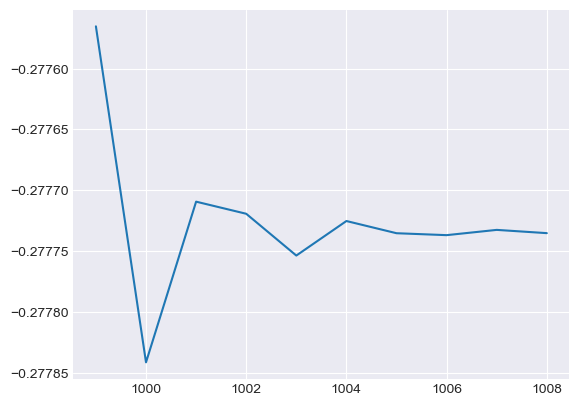

In [289]:
forecast_results.plot()

In [ ]:
feature_vector = 

**ARIMA Markov Chain**

In [270]:
# arima_markov_chain = MarkovChain(states, states_dict)
import warnings
warnings.filterwarnings("ignore")
arima_markov_chain = MarkovChain(states, states_dict)

for pair, data in coint_dict.items():
    print(f"Running through {pair}")
    first_pair, second_pair = pair
    current_price = round(compute_spread(pair).iloc[-1], 5)
    
    # Using the entire data to train the ARIMA model.
    
    model = ARIMA(data[:-1], order=(2, 1, 2))
    model_fit = model.fit()
    
    # Forecast the next step (today's prediction).
    forecast_results = model_fit.forecast()
    prediction_today = round(forecast_results.iloc[0], 4)
     
    # print(f"Current State for {pair}: {current_state}")
    
    print(f"Prediction for today for {pair}: {prediction_today}. Current price - {current_price}")
    
    if prediction_today > current_price:  # predicted spread is widening
        print(f"Signal: Sell {first_pair}, Buy {second_pair}")
        orders["sell"].append(first_pair)
        orders["buy"].append(second_pair)
    elif prediction_today < current_price:  # predicted spread is contracting
        print(f"Signal: Buy {first_pair}, Sell {second_pair}")
        orders["buy"].append(first_pair)
        orders["sell"].append(second_pair)
        
    print("-----")


30/30 [==============================] - 0s 648us/step
Running through ('AUDUSD.a', 'NZDUSD.a')


AttributeError: 'MarkovChain' object has no attribute 'classify_into_state'

**Normal ARIMA Predictions**

In [348]:
data = arima_get_data('AUDUSD.a')
model = ARIMA(data[:-1], order=(2, 1, 2))
model_fit = model.fit()

# Forecast the next step (today's prediction).
forecast_results = model_fit.forecast()

prediction_today = round(forecast_results.iloc[0], 4)

print(forecast_results)

5999    0.633065
dtype: float64


In [344]:
arima_orders = {
    "buy": [],
    "sell": []
}
for pair, data in coint_dict.items():
    print(f"Running through {pair}")
    first_pair, second_pair = pair
    current_price = round(arima_compute_spread(pair).iloc[-1], 5)
    
    # Using the entire data to train the ARIMA model.
    
    model = ARIMA(data[:-1], order=(2, 1, 2))
    model_fit = model.fit()
    
    # Forecast the next step (today's prediction).
    forecast_results = model_fit.forecast()
    
    prediction_today = round(forecast_results.iloc[0], 4)
    
    print(f"Prediction for today for {pair}: {prediction_today}. Current price - {current_price}")
    
    if predictions_today[pair] > current_price:  # predicted spread is widening
        print(f"Signal: Sell {first_pair}, Buy {second_pair}")
        arima_orders["sell"].append(first_pair)
        arima_orders["buy"].append(second_pair)
    elif predictions_today[pair] < current_price:  # predicted spread is contracting
        print(f"Signal: Buy {first_pair}, Sell {second_pair}")
        arima_orders["buy"].append(first_pair)
        arima_orders["sell"].append(second_pair)
        
        print("-----")

Running through ('AUDUSD.a', 'NZDUSD.a')
Prediction for today for ('AUDUSD.a', 'NZDUSD.a'): 0.0412. Current price - 0.04038
Signal: Buy AUDUSD.a, Sell NZDUSD.a
-----
Running through ('EURUSD.a', 'GBPUSD.a')
Prediction for today for ('EURUSD.a', 'GBPUSD.a'): -0.1632. Current price - -0.16332
Signal: Buy EURUSD.a, Sell GBPUSD.a
-----
Running through ('EURNZD.a', 'GBPNZD.a')
Prediction for today for ('EURNZD.a', 'GBPNZD.a'): -0.2775. Current price - -0.27598
Signal: Buy EURNZD.a, Sell GBPNZD.a
-----


In [330]:
arima_open_positions = mt5.positions_get()

arima_current_positions = {
    "buy": [],
    "sell": []
}
    
for i in arima_open_positions:
    if 'ARIMA' in i.comment:
        if i.type == 0:
            arima_current_positions['buy'].append(i.symbol)
        else:
            arima_current_positions['sell'].append(i.symbol)
        
arima_current_positions

{'buy': [], 'sell': []}

In [331]:
# First, close any mismatched positions:
for action, pairs in arima_current_positions.items():
    for pair in pairs:
        if pair not in orders[action]:
            # Close this position, it's not in the intended orders.
            position = next((p for p in arima_open_positions if p.symbol == pair), None)
            if position:
                close_position(position)

# Then, proceed with your order opening logic:
lot = 0.5
for pair in arima_orders['sell']:
    if not is_order_open(pair, 'sell', 'ARIMA'):
        send_order(pair, 'sell', lot, 'ARIMA')

for pair in arima_orders['buy']:
    if not is_order_open(pair, 'buy','ARIMA'):
        for key, val in hedge_ratios.items():
            if pair in key:
                send_order(pair, 'buy', round(lot * val, 2), 'ARIMA')

**GARCH Code**

## Other Technical Analyis tools

# Risk Management Protocols

### Monte Carlo Simulation for Forecasting Returns
Run Monte Carlo simulations based on the forecasts from all your trading models.
Analyze the simulation results to understand the range of possible returns for different risk levels and adjust accordingly.

Steps:
1. Use the forecasted returns from your ARIMA, GARCH, and other models.
2. Perform Monte Carlo simulations to generate a distribution of possible portfolio returns.

Analyze the risk and return trade-offs and make adjustments to your trading strategy accordingly.

**Calculating Scenario Probabilities for Weighted Returns**
Calculate the probability of each scenario (e.g., high return, medium return, low return) occurring.

Use these probabilities to calculate a weighted average return, giving you a more realistic expectation of your portfolio's performance.
Steps:
1. Use statistical methods, machine learning, or real market data to calculate the probability of each scenario.
2. Calculate the weighted average return by multiplying the return of each scenario by its probability and summing these up.

### GARCH Individual Symbol Optimization

Optimize the lot-size of each currency symbol based on the symbols GARCH values for either a more risk on or risk off approach. 

In [326]:
def get_exp():
    
    open_positions = mt5.positions_get()
    from collections import defaultdict
    net_exposure = defaultdict(float)
    for position in open_positions:
        base_currency = position.symbol[:3]
        quote_currency = position.symbol[3:6]
        volume = position.volume
        side = "Buy" if "Buy" in position.comment else "Sell"
        position_type = position.type

        if side == "Buy":
            if position_type == mt5.POSITION_TYPE_BUY:
                net_exposure[base_currency] += volume
                net_exposure[quote_currency] -= volume
            else:
                net_exposure[base_currency] -= volume
                net_exposure[quote_currency] += volume
        else:
            if position_type == mt5.POSITION_TYPE_SELL:
                net_exposure[base_currency] -= volume
                net_exposure[quote_currency] += volume
            else:
                net_exposure[base_currency] += volume
                net_exposure[quote_currency] -= volume

    for currency, exposure in net_exposure.items():
        print(f"{currency}: {exposure:.2f} lots")

        # if abs(exposure) > 0.75:
        #     print(f'{currency} is over exposed.')
        #     OE[currency] = exposure
get_exp()

AUD: -1.31 lots
USD: 0.06 lots
EUR: -2.30 lots
NZD: 1.55 lots
GBP: 2.00 lots
